<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 9: Filterung
## Vorwärtsmodellierung
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

# Create 3D forward model with spheres

In this notebook, we define spheres as geometries for forward modelling for **gravity** and
**magnetic** predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def change_fontsize(SMALL_SIZE=15,MEDIUM_SIZE=20,BIGGER_SIZE=25):
    """
    re-set matplotlib fonts with three different sizes:
    SMALL_SIZE=15 (default)
    MEDIUM_SIZE=20 (default)
    BIGGER_SIZE=25 (default)
    """
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
change_fontsize()

## Define forward modelling operators

----
### Gravity

The three components of the gravity vector are:
$$
\begin{array}{rcl}
\Delta g_x    & = & \frac{4}{3} \pi G \Delta \rho R^3 
                     \frac{x_p-x_o}{((x_p-x_o)^2 + (y_p-y_o)^2 + (z_p-z_o)^2)^{\frac{3}{2}}}\\
\Delta g_y    & = & \frac{4}{3} \pi G \Delta \rho R^3 
                     \frac{y_p-y_o}{((x_p-x_o)^2 + (y_p-y_o)^2 + (z_p-z_o)^2)^{\frac{3}{2}}}\\
\Delta g_z    & = & \frac{4}{3} \pi G \Delta \rho R^3 
                     \frac{z_p-z_o}{((x_p-x_o)^2 + (y_p-y_o)^2 + (z_p-z_o)^2)^{\frac{3}{2}}}
\end{array}
$$
Here, $G=6.672 \times 10^{-11}$ m$^3$/kg/s$^2$ is the gravitational constant,
$R$ [m] the radius of the sphere, $\rho$ [kg/$^3$] the density of the sphere,
$(x_o,y_o,z_o)$ [m] the coordinate of the observation point, and
$(x_p,y_p,z_p)$ [m] the coordinate of the center of the sphere.


In [3]:
def grav_sphere(xo,yo,zo,xp,yp,zp,radius,rho):
    """
    !-----------------------------------------------------------------------
    ! Bouguer-Anomaly for a buried sphere
    ! x-axis is north, z-axis vertically down
    !
    ! Input parameters:
    ! xo,yo,zo [m]       - location of observation point
    ! xp,yp,zp [m]       - location of center of sphere
    ! rho [kg/m^3]       - density difference
    ! radius [m]         - radius of sphere
    !
    ! Output parameter:
    ! gx,gy,gz [mGal]    - gravity component at observation point
    !
    ! from:
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    G       = 6.672e-11     # m^3/kg/s^2
    si2mgal = 1.e5          # m/s^2 -> mGal

    rx   = xo - xp
    ry   = yo - yp
    rz   = zo - zp
    r    = rx**2 + ry**2 + rz**2
    if (r == 0):
        print ('grav_sphere: obs. point in centrum of sphere')
    r    = np.sqrt(r)
    r3   = r**3
    mass = 4./3.*np.pi*rho*radius**3
    gx = -G * mass * rx/ r3 * si2mgal
    gy = -G * mass * ry/ r3 * si2mgal
    gz = -G * mass * rz/ r3 * si2mgal
    return gx,gy,gz

In [4]:
def grav_box(xo,yo,zo,x1,x2,y1,y2,z1,z2,rho):
    """
    !-----------------------------------------------------------------------
    ! Bouguer-Anomaly for a rectangular box
    !
    ! Input parameters:
    ! xo,yo,zo [m]       - location of observation point
    ! x1,x2 [m]          - location of left and right x-coordinates
    ! y1,y2 [m]          - location of left and right y-coordinates
    ! z1,z2 [m]          - location of top and bottom z-coordinates
    ! rho [kg/m^3]       - density difference
    !
    ! Output parameter:
    ! gz [mGal]          - vertical gravity at observation point
    !
    ! from: 
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    G       = 6.672e-11     # m^3/kg/s^2
    si2mgal = 1.e5          # m/s^2 -> mGal
    isign = np.array([-1,1])
    x    = np.zeros(2); y = np.zeros(2); z = np.zeros(2)
    x[0] = xo - x1
    x[1] = xo - x2
    y[0] = yo - y1
    y[1] = yo - y2
    z[0] = zo - z1
    z[1] = zo - z2
    gsum  = 0.
    for i in range(2):
        for j in range(2):
            for k in range(2):
                rijk = np.sqrt(x[i]**2 + y[j]**2 + z[k]**2)
                ijk  = isign[i] * isign[j] * isign[k]
                arg1 = np.arctan2((x[i]*y[j]),(z[k]*rijk))
                if (arg1 < 0.):
                    arg1 = arg1 + 2.*np.pi
                arg2 = rijk + y[j]
                arg3 = rijk + x[i]
                if (arg2 < 0.):
                    print ('grav_box: arg2 bad field point')
                if (arg3 < 0.):
                    print ('grav_box: arg3 bad field point')
                arg2 = np.log(arg2)
                arg3 = np.log(arg3)
                gsum  = gsum + float(ijk)*(z[k]*arg1 - x[i]*arg2 - y[j]*arg3)

    gz = G * rho * gsum * si2mgal
    return gz

**Compare sphere and box:**

A box with side length $a$, $b$, and $c$ is defined by the volume $V_b=a b c$.

From the volume of a sphere, $V_s={{4}\over{3}} \pi R^3$, the equivalent sphere radius follows from
$V_b=V_s$:
$$
R^3 = \frac{3 a b c}{4 \pi} 
$$

Using $a=b=c=2$ m, results in $R \simeq 1.24$ m.

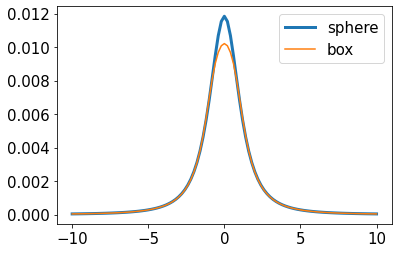

In [6]:
x = np.linspace(-10,10,101)
boug_sphere = np.array([])
boug_box    = np.array([])
for i in range(len(x)):
    gx,gy,gz = grav_sphere(xo=x[i],yo=0,zo=0,xp=0,yp=0,zp=1.5,radius=1.24,rho=500)
    boug_sphere = np.append(boug_sphere,gz)
    gz = grav_box(xo=x[i],yo=0,zo=0,x1=-1,x2=1,y1=-1,y2=1,z1=0.5,z2=2.5,rho=500)
    boug_box = np.append(boug_box,gz)
    
plt.plot(x,boug_sphere,lw=3,label='sphere')
plt.plot(x,boug_box,label='box')
plt.legend()

**Compare mass below and above observation point:**

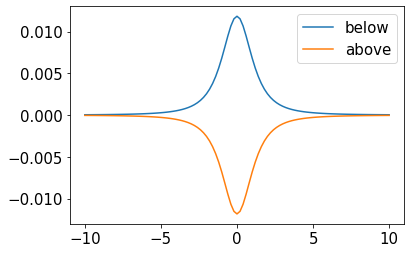

In [7]:
x = np.linspace(-10,10,101)
boug_sphere_below = np.array([])
boug_sphere_above = np.array([])
for i in range(len(x)):
    gx,gy,gz = grav_sphere(xo=x[i],yo=0,zo=0,xp=0,yp=0,zp=1.5,radius=1.24,rho=500)
    boug_sphere_below = np.append(boug_sphere_below,gz)
    gx,gy,gz = grav_sphere(xo=x[i],yo=0,zo=0,xp=0,yp=0,zp=-1.5,radius=1.24,rho=500)
    boug_sphere_above = np.append(boug_sphere_above,gz)
    
plt.plot(x,boug_sphere_below,label='below')
plt.plot(x,boug_sphere_above,label='above')
plt.legend()

In [ ]:
print('below')
gx,gy,gz = grav_sphere(xo=0,yo=0,zo=0,xp=0,yp=0,zp=1.5,radius=1.,rho=500)
print (gx,gy,gz)
gz = grav_box(xo=0,yo=0,zo=0,x1=-1,x2=1,y1=-1,y2=1,z1=1,z2=2,rho=500)
print (gz)

print('above')
gx,gy,gz = grav_sphere(xo=0,yo=0,zo=0,xp=0,yp=0,zp=-1.5,radius=1.,rho=500)
print (gx,gy,gz)
gz = grav_box(xo=0,yo=0,zo=0,x1=-1,x2=1,y1=-1,y2=1,z1=-1,z2=-2,rho=500)
print (gz)

----
### Magnetics

The three components of the magnetic induction $\vec{B}$ and the total-field anomaly $T$ are:
$$
\begin{array}{rcl}
 \Delta B_x    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_x - r^2 m_x\right)\\
 \Delta B_y    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_y - r^2 m_y\right)\\
 \Delta B_z    & = & \frac{\mu_0}{4\pi} \frac{{4 \over 3} \pi R^3 M}{r^5}
                     \left( 3(\hat{m}_x r_x + \hat{m}_y r_y + \hat{m}_z r_z) r_z - r^2 m_z\right)\\
 \Delta T      & = & \hat{B}_x \Delta B_x + \hat{B}_y \Delta B_y + \hat{B}_z \Delta B_z
\end{array}
$$
Here, $\mu_0 = 10^{-7}$ Vs/Am is the permeability of vacuum,
$R$ [m] the radius of the sphere, $M$ [A/m] the magnetisation of the sphere,
$(x_o,y_o,z_o)$ [m] the coordinate of the observation point, and
$(x_p,y_p,z_p)$ [m] the coordinate of the center of the sphere.

In [8]:
def dircos(incl,decl,azim):
    """
    !-----------------------------------------------------------------------
    ! Input parameters:
    ! incl [degrees]     - inclination positive below horizontal
    ! decl [degrees]     - declination positive east from north
    ! azim [degrees]     - azimuth of x axis in degrees positive east to north
    ! Output parameter:
    ! a,b,c              - three direction cosines
    !
    ! from: 
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    deg2rad = np.pi / 180.

    a = np.cos(incl*deg2rad) * np.cos((decl-azim)*deg2rad)
    b = np.cos(incl*deg2rad) * np.sin((decl-azim)*deg2rad)
    c = np.sin(incl*deg2rad)
    return a,b,c

In [9]:
def mag_sphere (xo,yo,zo,xp,yp,zp,radius,earthincl,earthdecl,mag,incl,decl,theta):
    """
    !-----------------------------------------------------------------------
    ! Magnetic anomaly of a uniformly magnetised sphere.
    ! x-axis is north, z-axis vertically down
    !
    ! Input parameters:
    ! xo,yo,zo [m]         - location of observation point
    ! xp,yp,zp [m]         - location of center of sphere
    ! radius [m]           - radius of sphere
    ! earthincl [degrees]  - inclination of earth field, positive below horizontal
    ! earthdecl [degrees]  - declination of earth field, positive east of true north
    ! mag [A/m]            - magnetisation      
    ! incl [degrees]       - inclination of magnetisation, positive below horizontal
    ! decl [degrees]       - declination of magnetisation, positive east of true north
    ! theta [degrees]      - azimuth of x axis in degrees positive east to north
    !
    ! Output parameter:
    ! bx,by,bz [nT]        - Magnetic induction component at observation point
    ! t [nT]               - Total field at observation point
    !
    ! from:
    ! Blakeley (1995): Potential theory in gravity & magnetic applications
    !-----------------------------------------------------------------------
    """
    mu04pi  = 1.000e-7      # Vs/Am
    t2nt    = 1.e9          # T -> nT
    mx,my,mz = dircos (incl,decl,theta)
    fx,fy,fz = dircos (earthincl,earthdecl,theta)

    rx   = xo - xp
    ry   = yo - yp
    rz   = zo - zp
    r2   = rx**2 + ry**2 + rz**2
    if (r2 == 0):
        print ('mag_sphere: obs point in centrum of sphere')
    r    = np.sqrt(r2)
    r5   = r**5
    dot  = rx*mx + ry*my + rz*mz
    moment = 4./3.*np.pi*mag*radius**3
    bx = t2nt * mu04pi * moment * (3.*dot*rx - r2*mx) / r5
    by = t2nt * mu04pi * moment * (3.*dot*ry - r2*my) / r5
    bz = t2nt * mu04pi * moment * (3.*dot*rz - r2*mz) / r5
    t  = fx*bx + fy*by + fz*bz
    return bx,by,bz,t

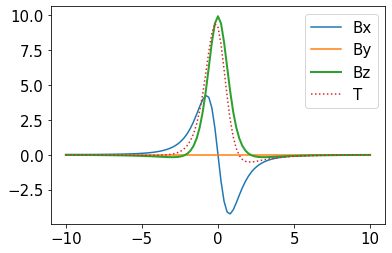

In [14]:
x = np.linspace(-10,10,101)
mag_bx = np.array([])
mag_by = np.array([])
mag_bz = np.array([])
mag_t  = np.array([])
for i in range(len(x)):
    bx,by,bz,t = mag_sphere(xo=x[i],yo=0,zo=0,xp=0,yp=0,zp=1.5,radius=1.,
                        earthincl=67.,earthdecl=0.,mag=0.04,incl=90.,decl=0.,theta=0.)
    mag_bx = np.append(mag_bx,bx)
    mag_by = np.append(mag_by,by)
    mag_bz = np.append(mag_bz,bz)
    mag_t  = np.append(mag_t,t)
    
    
plt.plot(x,mag_bx,label='Bx')
plt.plot(x,mag_by,label='By')
plt.plot(x,mag_bz,label='Bz',linewidth=2)
plt.plot(x,mag_t,label='T',linestyle=':')
plt.legend()

In [ ]:
plt.plot(x,mag_bz-mag_t)

... done